In [1]:
import pandas as pd
import pymysql 
from functools import reduce
import numpy as np
import textstat
import nltk
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import random

con = pymysql.connect(host='localhost', user='root', passwd='qwer', db='amazon', port = 3306) 
cur = con.cursor()

def read_table(cur, sql_order): # sql_order is a string
     try:
         cur.execute(sql_order) 
         data  = cur.fetchall(  )
         frame = pd.DataFrame(list(data))
     except: #, e:
         frame = pd.DataFrame()
         # print e
         # continue 
     return frame
 
df_train = read_table(cur,'select * from final_train200') #35000 line－>80k line－>170k
df_val = read_table(cur,'select * from final_val200') #5000 line->5k line->10k
df_test = read_table(cur,'select * from final_test200') #10000 line->10k line->20k

cur.close()
con.close()
df = pd.concat([df_train,df_val,df_test], axis=0)
df = pd.DataFrame(df)  #df is turple, need to convert to dataframe
print(df.shape)
pd.set_option('max_colwidth',50)
df.head()

(200000, 5)


,0,1,2,3,4
0,There is nothing special about this streamer. ...,Mediocre,A100WO06OQR8BQ,"Duffer. ""Bo""",2
1,"For starters, I did not receive the keyboard t...",Can't Use,A100WO06OQR8BQ,"Duffer. ""Bo""",3
2,My home is located about half way between wher...,"So Far, So Good",A100WO06OQR8BQ,"Duffer. ""Bo""",4
3,"In the box is the quite attractive unit, a fil...",Almost,A100WO06OQR8BQ,"Duffer. ""Bo""",5
4,I have reviewed this previously but it shows a...,Repeat Review,A100WO06OQR8BQ,"Duffer. ""Bo""",6


In [2]:
## customer name has some consistency problem with mysql and pandas.
## since in mysql, we choose 1 id per name, thus id can also be used as the single identity as name.
## we will choose custom_id as the Y label, drop custom name.
df = df.rename(columns={0:'description',1:'title',2:'custom_id',3:'custom_name', 4:'row_num'})
print(df['custom_name'].nunique())
print(df['custom_id'].nunique())
df = df.drop(['custom_name','row_num'], axis=1)
df.head()

1002
1000


,description,title,custom_id
0,There is nothing special about this streamer. ...,Mediocre,A100WO06OQR8BQ
1,"For starters, I did not receive the keyboard t...",Can't Use,A100WO06OQR8BQ
2,My home is located about half way between wher...,"So Far, So Good",A100WO06OQR8BQ
3,"In the box is the quite attractive unit, a fil...",Almost,A100WO06OQR8BQ
4,I have reviewed this previously but it shows a...,Repeat Review,A100WO06OQR8BQ


In [3]:
## encode custom_id to int
def get_series_ids(x):
    '''Function returns a pandas series consisting of ids, 
       corresponding to objects in input pandas series x
       Example: 
       get_series_ids(pd.Series(['a','a','b','b','c'])) 
       returns Series([0,0,1,1,2], dtype=int)'''

    values = np.unique(x)
    values2nums = dict(zip(values,range(len(values))))
    return x.replace(values2nums)
df['custom_id'] = get_series_ids(df['custom_id'])   #use int encoding for custome_id
df.head()

,description,title,custom_id
0,There is nothing special about this streamer. ...,Mediocre,0
1,"For starters, I did not receive the keyboard t...",Can't Use,0
2,My home is located about half way between wher...,"So Far, So Good",0
3,"In the box is the quite attractive unit, a fil...",Almost,0
4,I have reviewed this previously but it shows a...,Repeat Review,0


In [4]:
##extract pos of TAG feature
def SyntacticFeatures(chapters):
    """
    Extract feature vector for part of speech frequencies
    """
    def token_to_pos(ch):
        tokens = nltk.word_tokenize(ch)
        return [p[1] for p in nltk.pos_tag(tokens)]

    chapters_pos = [token_to_pos(ch) for ch in chapters]
    pos_list = ['NN', 'NNP', 'DT', 'IN', 'JJ', 'NNS','UH','PDT','MD']
    fvs_syntax = np.array([[ch.count(pos) for pos in pos_list]
                           for ch in chapters_pos]).astype(np.float64)

    # normalise by dividing each row by number of tokens in the chapter
    fvs_syntax /= np.c_[np.array([len(ch) for ch in chapters_pos])]

    return fvs_syntax, len(pos_list)

chapters = df['description'].values.tolist()
desc_syntax_statis,tag_num = SyntacticFeatures(chapters)
print(desc_syntax_statis.shape)
desc_syntax_statis =  pd.DataFrame(desc_syntax_statis)
desc_syntax_statis.columns = ['desc_tag_'+str(i+1) for i in range(tag_num)]

chapters = df['title'].values.tolist()
title_syntax_statis,tag_num  = SyntacticFeatures(chapters)
print(title_syntax_statis.shape)
title_syntax_statis =  pd.DataFrame(title_syntax_statis)
title_syntax_statis.columns = ['title_tag_'+str(i+1) for i in range(tag_num)]

df.reset_index(inplace=True, drop=True)
df = pd.concat([df, title_syntax_statis, desc_syntax_statis], axis=1)
del desc_syntax_statis,title_syntax_statis
print(df.shape)

(200000, 9)
(200000, 9)
(200000, 21)


In [5]:
#bag of words feature
def BagOfWords(all_text,chapters,num_of_words):
    """
    Compute the bag of words feature vectors, based on the most common words
     in the whole book
    """
    # get most common words in the whole text_file
    NUM_TOP_WORDS = num_of_words
    tokens = nltk.word_tokenize(all_text)
    tokens = [w.lower() for w in tokens]
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    #lemmatize
    wnl = WordNetLemmatizer() 
    words = [wnl.lemmatize(w) for w in words]
    
    fdist = nltk.FreqDist(words)
    #print(fdist)
    vocab= fdist.most_common(num_of_words)
    print(vocab)

    # use sklearn to create the bag for words feature vector for each chapter
    vectorizer = CountVectorizer(vocabulary=vocab, tokenizer=nltk.word_tokenize)
    fvs_bow = vectorizer.fit_transform(chapters).toarray().astype(np.float64)

    # normalise by dividing each row by its Euclidean norm
    fvs_bow /= 0.00001+np.c_[np.apply_along_axis(np.linalg.norm, 1, fvs_bow)]
    return fvs_bow

all_text = reduce(lambda x,y: x+y, random.sample(df['description'].values.tolist(),5000))
print("corpus length",len(all_text))
chapters = df['description'].values.tolist()
num_of_words = 20
desc_bow = BagOfWords(all_text,chapters, num_of_words)
print(desc_bow.shape)
desc_bow =  pd.DataFrame(desc_bow)
desc_bow.columns = ['desc_bow_'+str(i+1) for i in range(num_of_words)]


all_text = reduce(lambda x,y: x+y, df['title'].values.tolist())
print("corpus length",len(all_text))
chapters = df['title'].values.tolist()
num_of_words = 20
title_bow = BagOfWords(all_text,chapters, num_of_words)
print(title_bow.shape)
title_bow =  pd.DataFrame(title_bow)
title_bow.columns = ['title_bow_'+str(i+1) for i in range(num_of_words)]

df.reset_index(inplace=True, drop=True)
df = pd.concat([df, title_bow, desc_bow], axis=1)
del desc_bow,title_bow
print(df.shape)

corpus length 7085314
[('the', 70746), ('a', 43292), ('and', 36850), ('to', 31746), ('of', 31162), ('is', 22762), ('i', 21190), ('it', 20476), ('in', 18323), ('that', 15294), ('this', 14003), ('for', 12075), ('s', 10975), ('with', 10435), ('you', 9776), ('on', 8406), ('but', 8149), ('are', 7846), ('wa', 7594), ('not', 7112)]
(200000, 20)
corpus length 6656966
[('the', 34165), ('a', 32893), ('and', 24361), ('of', 23987), ('for', 20981), ('to', 17728), ('but', 14063), ('it', 10636), ('s', 9687), ('is', 9547), ('great', 9397), ('in', 9141), ('this', 8547), ('good', 8473), ('not', 8289), ('with', 7293), ('i', 6997), ('book', 6953), ('you', 6776), ('on', 5945)]
(200000, 20)
(200000, 61)


In [6]:
'''
##sentence embedding, 700dim
import sent2vec
model = sent2vec.Sent2vecModel()
model.load_model('torontobooks_unigrams.bin')
n_dim = 700
title_emb =  pd.DataFrame(model.embed_sentences(df['title'].values))
title_emb.columns = ['title_emb_'+str(i+1) for i in range(n_dim)]

desc_emb =  pd.DataFrame(model.embed_sentences(df['description'].values))
desc_emb.columns = ['desc_emb_'+str(i+1) for i in range(n_dim)]
#desc_emb.head()

## embedding is too large, can't use it
def emb_drop(emb,col_prefix):
    for i in range(n_dim):
        if i%10 !=0: #drop 9/10
            temp = col_prefix+str(i+1)
            emb = emb.drop([temp],axis=1)
    return emb
            
title_emb=emb_drop(title_emb,'title_emb_')
desc_emb=emb_drop(desc_emb,'desc_emb_')
print(title_emb.shape)
print(desc_emb.shape)
df.reset_index(inplace=True, drop=True)
df = pd.concat([df, title_emb, desc_emb], axis=1)
del desc_emb,title_emb
print(df.shape)
'''

"\n##sentence embedding, 700dim\nimport sent2vec\nmodel = sent2vec.Sent2vecModel()\nmodel.load_model('torontobooks_unigrams.bin')\nn_dim = 700\ntitle_emb =  pd.DataFrame(model.embed_sentences(df['title'].values))\ntitle_emb.columns = ['title_emb_'+str(i+1) for i in range(n_dim)]\n\ndesc_emb =  pd.DataFrame(model.embed_sentences(df['description'].values))\ndesc_emb.columns = ['desc_emb_'+str(i+1) for i in range(n_dim)]\n#desc_emb.head()\n\n## embedding is too large, can't use it\ndef emb_drop(emb,col_prefix):\n    for i in range(n_dim):\n        if i%10 !=0: #drop 9/10\n            temp = col_prefix+str(i+1)\n            emb = emb.drop([temp],axis=1)\n    return emb\n            \ntitle_emb=emb_drop(title_emb,'title_emb_')\ndesc_emb=emb_drop(desc_emb,'desc_emb_')\nprint(title_emb.shape)\nprint(desc_emb.shape)\ndf.reset_index(inplace=True, drop=True)\ndf = pd.concat([df, title_emb, desc_emb], axis=1)\ndel desc_emb,title_emb\nprint(df.shape)\n"

In [7]:
#feature of readability
df['description_syllable_cnt'] = df['description'].apply(lambda x: textstat.syllable_count(x, lang='en_US'))
df['title_syllable_cnt'] = df['title'].apply(lambda x: textstat.syllable_count(x, lang='en_US'))

#count number of words by removing punction
df['description_num_words'] = df['description'].apply(lambda x: textstat.lexicon_count(x, removepunct=True))
df['title_num_words'] = df['title'].apply(lambda x: textstat.lexicon_count(x, removepunct=True))

df['description_easy_level'] = df['description'].apply(lambda x: textstat.flesch_reading_ease(x))
df['title_easy_level'] = df['title'].apply(lambda x: textstat.flesch_reading_ease(x))

df['description_FK_level'] = df['description'].apply(lambda x: textstat.flesch_kincaid_grade(x))
df['title_FK_level'] = df['title'].apply(lambda x: textstat.flesch_kincaid_grade(x))

df['description_GF_scale'] = df['description'].apply(lambda x: textstat.gunning_fog(x))
df['title_GF_scale'] = df['title'].apply(lambda x: textstat.gunning_fog(x))

df['description_LWF'] = df['description'].apply(lambda x: textstat.linsear_write_formula(x))
df['title_LWF'] = df['title'].apply(lambda x: textstat.linsear_write_formula(x))

df.head()

,description,title,custom_id,title_tag_1,title_tag_2,title_tag_3,title_tag_4,title_tag_5,title_tag_6,title_tag_7,...,description_num_words,title_num_words,description_easy_level,title_easy_level,description_FK_level,title_FK_level,description_GF_scale,title_GF_scale,description_LWF,title_LWF
0,There is nothing special about this streamer. ...,Mediocre,0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,335,1,67.18,36.62,9.1,8.4,14.81,40.4,7.285714,-0.5
1,"For starters, I did not receive the keyboard t...",Can't Use,0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,...,218,2,72.56,120.21,7.0,-3.1,13.58,0.8,6.000000,0.0
2,My home is located about half way between wher...,"So Far, So Good",0,0.0,0.200000,0.0,0.0,0.2,0.0,0.0,...,228,4,77.57,118.18,7.2,-2.3,14.79,1.6,8.666667,1.0
3,"In the box is the quite attractive unit, a fil...",Almost,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,185,1,78.08,36.62,7.0,8.4,13.89,0.4,7.000000,-0.5
4,I have reviewed this previously but it shows a...,Repeat Review,0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,56,2,85.49,35.61,4.1,8.8,10.19,0.8,4.000000,0.0


In [8]:
#feature from stop words
def stop_word_cnt(text):
    # split into words
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    # filter out stop words, and do lemmatizing
    stop_words = set(stopwords.words('english'))
    stops = [w for w in words if w in stop_words]
    return len(stops)

df['description_stp_cnt'] = df['description'].apply(lambda x: stop_word_cnt(x))
df['title_stp_cnt'] = df['title'].apply(lambda x: stop_word_cnt(x))
df['description_stp_ratio'] = df['description_stp_cnt']/df['description_num_words']
df['title_stp_ratio'] = df['title_stp_cnt']/df['title_num_words']
df.head()

,description,title,custom_id,title_tag_1,title_tag_2,title_tag_3,title_tag_4,title_tag_5,title_tag_6,title_tag_7,...,description_FK_level,title_FK_level,description_GF_scale,title_GF_scale,description_LWF,title_LWF,description_stp_cnt,title_stp_cnt,description_stp_ratio,title_stp_ratio
0,There is nothing special about this streamer. ...,Mediocre,0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,9.1,8.4,14.81,40.4,7.285714,-0.5,193,0,0.576119,0.0
1,"For starters, I did not receive the keyboard t...",Can't Use,0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,...,7.0,-3.1,13.58,0.8,6.000000,0.0,111,0,0.509174,0.0
2,My home is located about half way between wher...,"So Far, So Good",0,0.0,0.200000,0.0,0.0,0.2,0.0,0.0,...,7.2,-2.3,14.79,1.6,8.666667,1.0,119,2,0.521930,0.5
3,"In the box is the quite attractive unit, a fil...",Almost,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,7.0,8.4,13.89,0.4,7.000000,-0.5,89,0,0.481081,0.0
4,I have reviewed this previously but it shows a...,Repeat Review,0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,4.1,8.8,10.19,0.8,4.000000,0.0,30,0,0.535714,0.0


In [9]:
text_cols= ['description','title']
for cols in text_cols:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols + '_len'] = df[cols].map(lambda x: len(str(x))).astype(np.float16) #Lenth
    df[cols + "_upper_ratio"] = df[cols].apply(lambda x: sum(map(str.isupper, x)))/df[cols + '_len']
    df[cols + "_space_ratio"] = df[cols].apply(lambda x: x.count(' '))/df[cols + '_len']
    #df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    #df[cols + '_num_words'] = df[cols].apply(lambda comment: len(word_tokenize(comment)) # Count number of Words
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] # Count Unique Words
    #df[cols + '_num_letters'] = df[cols].apply(lambda comment: len(comment)) # Count number of Letters


# Extra Feature Engineering
df['title_desc_len_ratio'] = df['title_num_words']/df['description_num_words']
df['description_sentence_num'] = df['description'].apply(lambda comment: len(sent_tokenize(comment)))   
df['title_sentence_num'] = df['title'].apply(lambda comment: len(sent_tokenize(comment)))
df['title_desc_sentence_ratio'] =  df['title_sentence_num']/df['description_sentence_num']  
df['average_desc_sentence_words'] = df['description_num_words']/df['description_sentence_num']
df['average_desc_sentence_len'] = df['description_len']/df['description_sentence_num']
df['average_title_sentence_words'] = df['title_num_words']/df['title_sentence_num']
df['average_title_sentence_len'] = df['title_len']/df['title_sentence_num']

df['description_average_words_len'] = df['description_len']/df['description_num_words'] 
df['title_average_words_len'] = df['title_len']/df['title_num_words']

#punction features
df['description_comma_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count(','))/df['description_sentence_num']
df['description_semicolon_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count(';'))/df['description_sentence_num']
df['description_colon_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count(':'))/df['description_sentence_num']
df['description_excla_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count('!'))/df['description_sentence_num']
df['description_brack_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count('('))/df['description_sentence_num']
df['description_ques_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count('?'))/df['description_sentence_num']
df['description_dot_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count('.'))/df['description_sentence_num']
df['description_hyphen_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count('-'))/df['description_sentence_num']
df['description_quat_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count('"'))/df['description_sentence_num']
df['description_and_ratio'] = df['description'].apply(lambda x: word_tokenize(x).count('&'))/df['description_sentence_num']

df['title_comma_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count(','))/df['title_sentence_num']
df['title_semicolon_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count(';'))/df['title_sentence_num']
df['title_colon_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count(':'))/df['title_sentence_num']
df['title_excla_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count('!'))/df['title_sentence_num']
df['title_brack_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count('('))/df['title_sentence_num']
df['title_ques_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count('?'))/df['title_sentence_num']
df['title_dot_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count('.'))/df['title_sentence_num']
df['title_hypen_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count('-'))/df['title_sentence_num']
df['title_quat_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count('"'))/df['title_sentence_num']
df['title_and_ratio'] = df['title'].apply(lambda x: word_tokenize(x).count('&'))/df['title_sentence_num']
df.shape

(200000, 117)

In [10]:
### TFIDF Vectorizer for title###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
title_tfidf = tfidf_vec.fit_transform(df['title'].values.tolist() )
#print(title_tfidf)
### SVD Components ###
n_comp = 5
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(title_tfidf)
title_svd = pd.DataFrame(svd_obj.transform(title_tfidf))
title_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
title_svd.head()

,svd_title_1,svd_title_2,svd_title_3,svd_title_4,svd_title_5
0,0.002360,-0.000294,0.000275,-0.000680,0.000186
1,0.040390,-0.021127,-0.004192,0.043002,0.015997
2,0.122196,-0.058713,0.238371,-0.068152,-0.027490
3,0.006967,-0.001193,0.001091,0.003315,-0.000493
4,0.009681,-0.006186,-0.005841,-0.003848,0.006604


In [11]:
### TFIDF Vectorizer for description###
#get from https://www.kaggle.com/samratp/avito-lightgbm-with-ridge-feature-v-3-0-0-2219/code
english_stop = set(stopwords.words('english'))
tfidf_para = {
    "stop_words": english_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


tfidf_vec = TfidfVectorizer(ngram_range=(1,1), max_features=20000,**tfidf_para)  ##** means as dictionary
des_tfidf = tfidf_vec.fit_transform(df['description'].values.tolist() )

### SVD Components ###
n_comp = 10
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(des_tfidf)
des_svd = pd.DataFrame(svd_obj.transform(des_tfidf))
des_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
des_svd.head()

,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10
0,0.147411,0.028393,-0.008297,-0.012855,-0.028956,-0.069639,-0.007347,0.031262,-0.006619,0.013463
1,0.127627,0.096277,0.006690,-0.034563,0.013155,-0.070372,0.031915,-0.003273,0.004753,-0.031798
2,0.103958,0.064329,-0.024244,-0.037800,-0.012409,-0.019035,-0.000008,-0.020755,0.012235,-0.015715
3,0.116759,0.104831,-0.035261,-0.060978,-0.006680,-0.028974,0.007375,-0.022876,-0.014260,-0.041198
4,0.046275,0.028150,-0.010482,-0.011946,-0.008308,0.001104,-0.038105,-0.021703,-0.002910,0.004174


In [12]:
df.reset_index(inplace=True, drop=True)
df = pd.concat([df, title_svd, des_svd], axis=1)
del title_tfidf,des_tfidf, title_svd, des_svd

In [13]:
'''
from sklearn.feature_extraction.text import HashingVectorizer
num_desc_features = 20
num_title_features = 5
def desc_vectorizer(text):
    hv = HashingVectorizer(n_features=num_desc_features)
    encode = hv.transform(text).toarray()
    return encode

def title_vectorizer(text):
    hv = HashingVectorizer(n_features=num_title_features)
    encode = hv.transform(text).toarray()
    return encode

df['description'] =  df['description'].apply(lambda x: desc_vectorizer([x])) 
df['title'] = df['title'].apply(lambda x: title_vectorizer([x])) 

df.reset_index(inplace=True, drop=True)
for i in range(num_desc_features):
    temp_desc = []
    for j in range(50000):
        temp = df['description'].values
        temp_desc.append(temp[j][0][i])
    name = 'desc_hash_'+str(i)
    desc_frame = pd.DataFrame({name:temp_desc})
    df = pd.concat([df,desc_frame],axis=1)
for i in range(num_title_features):
    temp_title = []
    for j in range(50000):
        temp = df['title'].values
        temp_title.append(temp[j][0][i])
    name = 'title_hash_'+str(i)
    title_frame = pd.DataFrame({name:temp_title}) 
    df = pd.concat([df,title_frame],axis=1)
    
df.head()
'''

"\nfrom sklearn.feature_extraction.text import HashingVectorizer\nnum_desc_features = 20\nnum_title_features = 5\ndef desc_vectorizer(text):\n    hv = HashingVectorizer(n_features=num_desc_features)\n    encode = hv.transform(text).toarray()\n    return encode\n\ndef title_vectorizer(text):\n    hv = HashingVectorizer(n_features=num_title_features)\n    encode = hv.transform(text).toarray()\n    return encode\n\ndf['description'] =  df['description'].apply(lambda x: desc_vectorizer([x])) \ndf['title'] = df['title'].apply(lambda x: title_vectorizer([x])) \n\ndf.reset_index(inplace=True, drop=True)\nfor i in range(num_desc_features):\n    temp_desc = []\n    for j in range(50000):\n        temp = df['description'].values\n        temp_desc.append(temp[j][0][i])\n    name = 'desc_hash_'+str(i)\n    desc_frame = pd.DataFrame({name:temp_desc})\n    df = pd.concat([df,desc_frame],axis=1)\nfor i in range(num_title_features):\n    temp_title = []\n    for j in range(50000):\n        temp = df[

In [14]:
df = df.drop(['description','title'],axis=1)
print(df.shape)
df.head()

(200000, 130)


,custom_id,title_tag_1,title_tag_2,title_tag_3,title_tag_4,title_tag_5,title_tag_6,title_tag_7,title_tag_8,title_tag_9,...,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10
0,0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.147411,0.028393,-0.008297,-0.012855,-0.028956,-0.069639,-0.007347,0.031262,-0.006619,0.013463
1,0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.127627,0.096277,0.006690,-0.034563,0.013155,-0.070372,0.031915,-0.003273,0.004753,-0.031798
2,0,0.0,0.200000,0.0,0.0,0.2,0.0,0.0,0.0,0.0,...,0.103958,0.064329,-0.024244,-0.037800,-0.012409,-0.019035,-0.000008,-0.020755,0.012235,-0.015715
3,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.116759,0.104831,-0.035261,-0.060978,-0.006680,-0.028974,0.007375,-0.022876,-0.014260,-0.041198
4,0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046275,0.028150,-0.010482,-0.011946,-0.008308,0.001104,-0.038105,-0.021703,-0.002910,0.004174


In [15]:
# Thanks You Guillaume Martin for the Awesome Memory Optimizer!
# https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
df = reduce_mem_usage(df)    #reduce memory
df.head()

Memory usage of dataframe is 188.45 MB
Memory usage after optimization is: 50.93 MB
Decreased by 73.0%


,custom_id,title_tag_1,title_tag_2,title_tag_3,title_tag_4,title_tag_5,title_tag_6,title_tag_7,title_tag_8,title_tag_9,...,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10
0,0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.147461,0.028397,-0.008293,-0.012856,-0.028961,-0.069641,-0.007347,0.031250,-0.006618,0.013466
1,0,0.0,0.333252,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.127686,0.096252,0.006691,-0.034576,0.013153,-0.070374,0.031921,-0.003273,0.004753,-0.031799
2,0,0.0,0.199951,0.0,0.0,0.199951,0.0,0.0,0.0,0.0,...,0.103943,0.064331,-0.024246,-0.037811,-0.012405,-0.019043,-0.000008,-0.020752,0.012238,-0.015717
3,0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.116760,0.104858,-0.035248,-0.060974,-0.006680,-0.028976,0.007374,-0.022873,-0.014259,-0.041199
4,0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.046265,0.028152,-0.010483,-0.011948,-0.008308,0.001104,-0.038116,-0.021698,-0.002911,0.004173


In [16]:
## train-valid-test split, 80 items for traning, 5 items for validaiton, 15 items for testing.
train_x = df[0:170000].drop(['custom_id'],axis=1)  #80->170
train_y = df['custom_id'][0:170000].values
val_x = df[170000:180000].drop(['custom_id'],axis=1)  #5->10
val_y = df['custom_id'][170000:180000].values
test_x = df[180000:200000].drop(['custom_id'],axis=1) #15->20
test_y = df['custom_id'][180000:200000].values

In [17]:
params = {
        "objective" : "multiclass",
        "metric" : "multi_logloss",
        'boosting_type': 'gbdt',
        'num_class' : 1000,
        'max_bin' : 255,
        'metric_freq' : 5,
        "is_training_metric" : 'true',
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_freq" : 5,
        "bagging_seed" : 2018,
        "verbosity" : 1,
        'device': 'cpu',    
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [18]:
import lightgbm as lgb
def run_lgb(train_x, train_y, val_x, val_y ,test_x):
    print(train_x.shape, val_x.shape, test_x.shape)
    lgtrain = lgb.Dataset(train_x, label=train_y)
    lgval = lgb.Dataset(val_x, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], early_stopping_rounds=10, verbose_eval=10, evals_result=evals_result)   
    pred_test_y = model.predict(test_x, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result
pred_test, model, evals_result = run_lgb(train_x, train_y, val_x, val_y, test_x)
print("Done!")

(170000, 129) (10000, 129) (20000, 129)
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 5.91851
[20]	valid_0's multi_logloss: 5.60471
[30]	valid_0's multi_logloss: 5.3873
[40]	valid_0's multi_logloss: 5.22214
[50]	valid_0's multi_logloss: 5.08629
[60]	valid_0's multi_logloss: 4.9687
[70]	valid_0's multi_logloss: 4.86653
[80]	valid_0's multi_logloss: 4.77403
[90]	valid_0's multi_logloss: 4.69101
[100]	valid_0's multi_logloss: 4.61448
[110]	valid_0's multi_logloss: 4.54428
[120]	valid_0's multi_logloss: 4.47902
[130]	valid_0's multi_logloss: 4.41757
[140]	valid_0's multi_logloss: 4.36036
[150]	valid_0's multi_logloss: 4.30599
[160]	valid_0's multi_logloss: 4.25525
[170]	valid_0's multi_logloss: 4.20686
[180]	valid_0's multi_logloss: 4.16016
[190]	valid_0's multi_logloss: 4.11554
[200]	valid_0's multi_logloss: 4.07365
[210]	valid_0's multi_logloss: 4.03336
[220]	valid_0's multi_logloss: 3.9947
[230]	valid_0's multi_logloss: 3.95717
[240]	valid_0

In [19]:
## caculate the test rank1 accuracy:
print(pred_test.shape)
test_num = len(test_y)
right_num = 0
for i in range(test_num):
    if pred_test[i].tolist().index(max(pred_test[i])) == test_y[i]:
        right_num +=1
rank1_acc = right_num/test_num
print("rank1 accuracy is:",rank1_acc)

(20000, 1000)
rank1 accuracy is: 0.4382


In [20]:
## calculate collective-vote rank1 accuracy
num_per_author=20
from scipy import stats
right_num = 0
for i in range(int(test_num/num_per_author)):
    ten_out=[]
    for j in range(num_per_author):
        ten_out.append(pred_test[i*num_per_author+j].tolist().index(max(pred_test[i*num_per_author+j])))
    if stats.mode(ten_out)[0][0] == test_y[i*num_per_author+j]:
        right_num +=1
ten_vote_acc = right_num*num_per_author/test_num
print("20 vote rank1 accuracy is:",ten_vote_acc)

20 vote rank1 accuracy is: 0.962


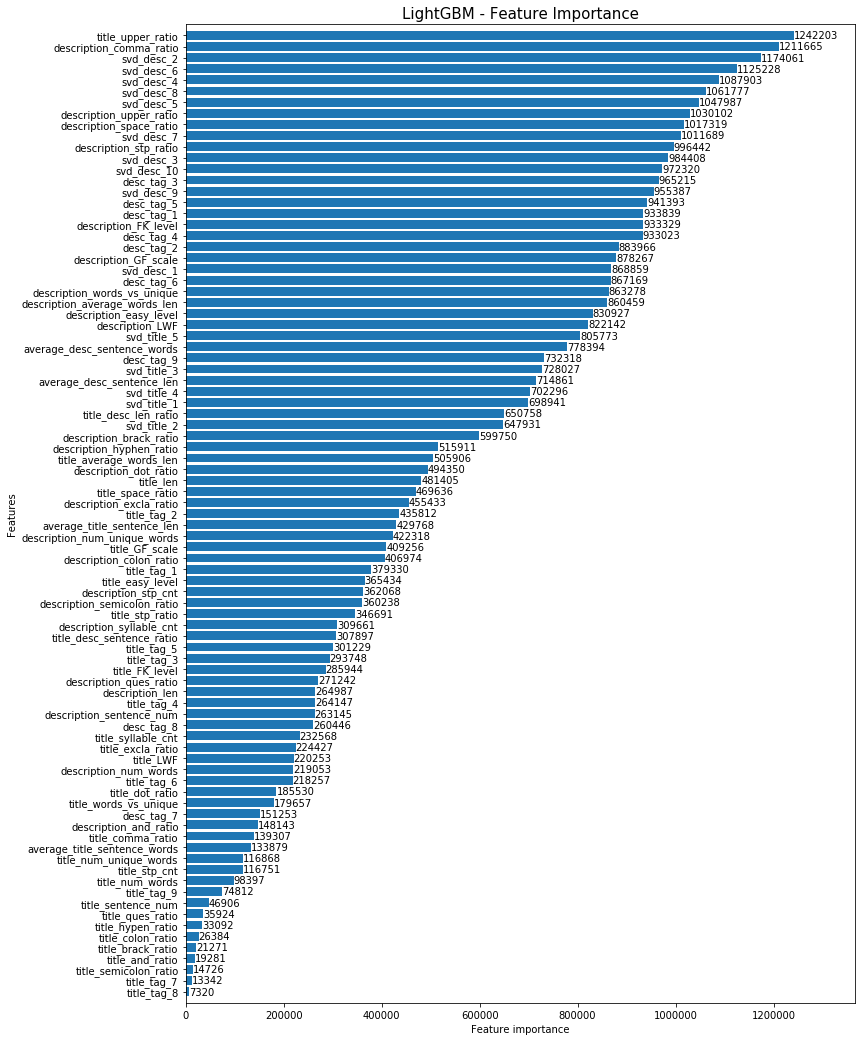

In [21]:
#show LGBM feature importance map
import matplotlib.pyplot as plt
%matplotlib inline  
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()